# Image De-blurring by Supervised Learning

## import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from math import log10
from tqdm import tqdm
import random
import os

## load data

In [ ]:
directory_data  = './data/'
filename_data   = 'assignment_11_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

original_train  = data['original_train']
blur_train      = data['blur_train']

original_test   = data['original_test']
blur_test       = data['blur_test']

num_data_train  = original_train.shape[0]
num_data_test   = original_test.shape[0]

print('*************************************************')
print('size of original_train :', original_train.shape)
print('size of blur_train :', blur_train.shape)
print('*************************************************')
print('size of original_test :', original_test.shape)
print('size of blur_test :', blur_test.shape)
print('*************************************************')
print('number of training image :', original_train.shape[0])
print('height of training image :', original_train.shape[1])
print('width of training image :', original_train.shape[2])
print('*************************************************')
print('number of testing image :', original_test.shape[0])
print('height of testing image :', original_test.shape[1])
print('width of testing image :', original_test.shape[2])
print('*************************************************')

*************************************************
size of original_train : (200, 256, 256)
size of blur_train : (200, 256, 256)
*************************************************
size of original_test : (100, 256, 256)
size of blur_test : (100, 256, 256)
*************************************************
number of training image : 200
height of training image : 256
width of training image : 256
*************************************************
number of testing image : 100
height of testing image : 256
width of testing image : 256
*************************************************


## hyper-parameters

In [ ]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 3000
size_minibatch  = 8
learning_rate   = 0.01
weight_decay    = 0.00001

## custom data loader for the PyTorch framework

In [ ]:
class dataset(Dataset):
    
    def __init__(self, original, blur, transform=False):
        
        self.original   = original
        self.blur       = blur 
        self.transform = transform
    
    def __getitem__(self, index):
        
        original    = self.original[index]
        blur        = self.blur[index]
        
        original    = torch.FloatTensor(original).unsqueeze(dim=0)
        blur        = torch.FloatTensor(blur).unsqueeze(dim=0)

        if self.transform:
            crop_size = [32, 32]
            # random crop
            top         = random.randint(0, original.shape[1] - crop_size[0])
            left        = random.randint(0, original.shape[2] - crop_size[1])
            original    = transforms.functional.crop(original, top, left, crop_size[0], crop_size[1])
            blur        = transforms.functional.crop(blur, top, left, crop_size[0], crop_size[1])
            
            # random horizontal flip
            if random.random() > 0.5: 
                original = transforms.functional.hflip(original)
                blur = transforms.functional.hflip(blur)

            # random vertical flip
            if random.random() > 0.5: 
                original = transforms.functional.vflip(original)
                blur = transforms.functional.vflip(blur)

        return (original, blur)
    
    def __len__(self):
        
        return self.original.shape[0]

## construct datasets and dataloaders for training and testing

In [ ]:
dataset_train_transform = dataset(original_train, blur_train, transform=True)
dataset_train           = dataset(original_train, blur_train)
dataset_test            = dataset(original_test, blur_test)

dataloader_train_transform  = DataLoader(dataset_train_transform, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_train            = DataLoader(dataset_train, batch_size=1, shuffle=False, drop_last=True)
dataloader_test             = DataLoader(dataset_test, batch_size=1, shuffle=False, drop_last=True)

## shape of the data when using the data loader

In [ ]:
(original_train, blur_train)  = dataset_train[0]
(original_test, blur_test)    = dataset_test[0]
(original_train_transform, blur_train_transform)  = dataset_train_transform[0]
print('*******************************************************************')
print('shape of the original in the training dataset:', original_train.shape)
print('shape of the blur in the training dataset:', blur_train.shape)
print('*******************************************************************')
print('shape of the original in the testing dataset:', original_test.shape)
print('shape of the blur in the testing dataset:', blur_test.shape)
print('*******************************************************************')
print('shape of the original in the training transform dataset:', original_train_transform.shape)
print('shape of the blur in the training transform dataset:', blur_train_transform.shape)
print('*******************************************************************')

*******************************************************************
shape of the original in the training dataset: torch.Size([1, 256, 256])
shape of the blur in the training dataset: torch.Size([1, 256, 256])
*******************************************************************
shape of the original in the testing dataset: torch.Size([1, 256, 256])
shape of the blur in the testing dataset: torch.Size([1, 256, 256])
*******************************************************************
shape of the original in the training transform dataset: torch.Size([1, 32, 32])
shape of the blur in the training transform dataset: torch.Size([1, 32, 32])
*******************************************************************


## class for the neural network 

In [ ]:
class Dense(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Dense, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.network = nn.Sequential(self.conv, nn.SiLU())

        # nn.init.xavier_uniform_(self.conv.weight, 0.1)
        # nn.init.kaiming_uniform_(self.conv.weight, a=math.sqrt(199), nonlinearity='leaky_relu')
        # nn.init.kaiming_uniform_(self.conv.weight)

    def forward(self, x):
        out = self.network(x)
        return torch.cat((x, out), 1)


class RDB(nn.Module):
    def __init__(self, in_channels, growth, dense_num):
        super(RDB, self).__init__()
        
        self.dense_layers = nn.Sequential(*[Dense(in_channels + growth * i, growth) for i in range(dense_num)])

        self.rdb_conv = nn.Conv2d(in_channels + growth * dense_num, growth, kernel_size=1, stride=1, padding=0, bias=True)

        # nn.init.xavier_uniform_(self.rdb_conv.weight, 0.1)
        # nn.init.kaiming_uniform_(self.rdb_conv.weight, a=math.sqrt(199), nonlinearity='leaky_relu')
        # nn.init.kaiming_uniform_(self.rdb_conv.weight)

    def forward(self, x):
        out = self.dense_layers(x)
        out = self.rdb_conv(out)
        return out + x


class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # Set Network Params
        self.num_features = 32
        self.growth = 32
        self.num_blocks = 2
        self.num_layers = 3



        # Shallow Feature extraction is encoder in autoencoder form I guess
        # -------------------------------------------------
        # Encoder
        # -------------------------------------------------
        self.e_layer1 = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=self.num_features, kernel_size=3, stride=1, padding=1, bias=True),  
                        # nn.MaxPool2d(2,2),
                        nn.SiLU(),
                        nn.BatchNorm2d(self.num_features),
        )
        
        self.e_layer2 = nn.Sequential(
                        nn.Conv2d(in_channels=self.num_features, out_channels=self.num_features, kernel_size=5, stride=1, padding=2, bias=True),
                        # nn.MaxPool2d(2,2),
                        nn.SiLU(),
                        nn.BatchNorm2d(self.num_features),
        )

        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels=self.num_features, out_channels=self.num_features, kernel_size=3, padding=1, bias=True),
                        nn.SiLU(),
                        nn.BatchNorm2d(self.num_features)
        )

        self.rdbs = nn.ModuleList([RDB(self.num_features, self.growth, self.num_layers)])
        for _ in range(self.num_blocks - 1):
            self.rdbs.append(RDB(self.growth, self.growth, self.num_layers))
        
        self.gff = nn.Sequential(
            nn.Conv2d(self.growth * self.num_blocks, self.num_features, kernel_size=1),
            nn.Conv2d(self.num_features, self.num_features, kernel_size=3, padding=1)
        )        
        
        self.conv2 = nn.Sequential(
                        nn.Conv2d(in_channels=self.num_features, out_channels=self.num_features, kernel_size=3, padding=1, bias=True),
                        nn.SiLU(),
                        nn.BatchNorm2d(self.num_features)
        )

        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------
        self.d_layer1 = nn.Sequential(
                        # nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                        nn.Conv2d(in_channels=self.num_features, out_channels=self.num_features, kernel_size=5, stride=1, padding=2, bias=True),
                        nn.SiLU(),
                        nn.BatchNorm2d(self.num_features),
        )
        
        self.d_layer2 = nn.Sequential(
                        # nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                        nn.Conv2d(in_channels=self.num_features, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.Sigmoid(),
        )


        # -------------------------------------------------
        # Network
        # -------------------------------------------------
        # self.network = nn.Sequential(
        #                 self.e_layer1,
        #                 self.e_layer2,
        #                 self.d_layer1, 
        #                 self.d_layer2,
        # )
        self.encoding_layer = nn.Sequential(
                            self.e_layer1,
                            # self.e_layer2
        )

        self.decoding_layer = nn.Sequential(
                            # self.d_layer1,
                            self.d_layer2
        )

        # self.initialize_weight()

    def forward(self,x):
        F_ = self.encoding_layer(x)
        F0 = self.conv1(F_)

        tmp = F0
        local_features = []
        for i in range(self.num_blocks):
            tmp = self.rdbs[i](tmp)
            local_features.append(tmp)
        
        tmp = self.gff(torch.cat(local_features, 1))
        tmp = self.conv2(tmp) * 0.3 + F_ * 0.7
        return self.decoding_layer(tmp) * 0.3 + x * 0.7


    # ======================================================================
    # initialize weights
    # ======================================================================
    def initialize_weight(self):
        for m in self.conv1.modules():
            
            if isinstance(m, nn.Conv2d):

                # nn.init.constant_(m.weight, 0.1) 
                nn.init.kaiming_uniform_(m.weight)
        
        for m in self.conv2.modules():
            
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)

                # nn.init.constant_(m.weight, 0.1) 

        for m in self.encoding_layer.modules():
            
            if isinstance(m, nn.Conv2d):

                # nn.init.constant_(m.weight, 0.1) 
                nn.init.kaiming_uniform_(m.weight)
                
                if m.bias is not None:

                    nn.init.constant_(m.bias, 1)
                    pass
                    
            elif isinstance(m, nn.BatchNorm2d):
                
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
                
            elif isinstance(m, nn.Linear):
                
                # nn.init.constant_(m.weight, 0.1) 
                nn.init.kaiming_uniform_(m.weight)

                if m.bias is not None:
                    
                    nn.init.constant_(m.bias, 1)
                    pass

        for m in self.decoding_layer.modules():
            
            if isinstance(m, nn.Conv2d):

                # nn.init.constant_(m.weight, 0.1) 
                nn.init.kaiming_uniform_(m.weight)
                
                if m.bias is not None:

                    nn.init.constant_(m.bias, 1)
                    pass
                    
            elif isinstance(m, nn.BatchNorm2d):
                
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
                
            elif isinstance(m, nn.Linear):
                
                # nn.init.constant_(m.weight, 0.1) 
                nn.init.kaiming_uniform_(m.weight)

                if m.bias is not None:
                    
                    nn.init.constant_(m.bias, 1)
                    pass


## build network

In [ ]:
model       = Network().to(device)
optimizer   = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [100, 160, 180], 0.5)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=50, step_size_down=100, mode='triangular')

## compute the prediction

In [ ]:
def compute_prediction(model, input):
    # ==================================================
    # fill up the blank
    #
    prediction = model(input)
    # 
    # ==================================================

    return prediction

## compute the loss

In [ ]:
def compute_loss(prediction, label):
    # ==================================================
    # fill up the blank
    #
    criterion   = nn.MSELoss()
    # 
    # ==================================================
    loss        = criterion(prediction, label)

    return loss

## compute the accuracy

In [ ]:
def compute_accuracy(prediction, label):

    prediction  = prediction.squeeze(axis=1)
    label       = label.squeeze(axis=1)
    mse_loss    = torch.mean((prediction - label) ** 2)

    if mse_loss == 0.0:
        psnr = 100
    else:
        psnr = 10 * torch.log10(1 / mse_loss)

    psnr = psnr.item()
    
    return psnr

## variables for the learning curve

In [ ]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train

In [ ]:
def train(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.train()

    for index_batch, (original, blur) in enumerate(dataloader):

        original    = original.to(device)
        blur        = blur.to(device)
        
        prediction  = compute_prediction(model, blur)
        loss        = compute_loss(prediction, original)
        accuracy    = compute_accuracy(prediction, original)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss.item())
        accuracy_epoch.append(accuracy)

    # scheduler.step()
    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    


## test

In [ ]:
def test(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.eval()

    for index_batch, (original, blur) in enumerate(dataloader):

        original    = original.to(device)
        blur        = blur.to(device)
        
        prediction  = compute_prediction(model, blur)
        loss        = compute_loss(prediction, original)
        accuracy    = compute_accuracy(prediction, original)

        loss_epoch.append(loss.item())
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    

## train and test

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=20, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

e = 0
early_stopping = EarlyStopping()
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, accuracy_train) = train(model, dataloader_train_transform)

    loss_mean_train[i]      = loss_train['mean']
    loss_std_train[i]       = loss_train['std']

    accuracy_mean_train[i]  = accuracy_train['mean']
    accuracy_std_train[i]   = accuracy_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, accuracy_test) = test(model, dataloader_test)

    loss_mean_test[i]      = loss_test['mean']
    loss_std_test[i]       = loss_test['std']

    accuracy_mean_test[i]  = accuracy_test['mean']
    accuracy_std_test[i]   = accuracy_test['std']
    early_stopping(loss_test['mean'], model)

    if early_stopping.early_stop:
        print("Early stopping")
        e = i
        print("Epochs until e:", e)
        break

    if (i % 10 == 0):
        print(accuracy_train['mean'], accuracy_test['mean'])
        
model.load_state_dict(torch.load('checkpoint.pt'))
loss_mean_train     = loss_mean_train[:e+1]
loss_std_train      = loss_std_train[:e+1]
accuracy_mean_train = accuracy_mean_train[:e+1]
accuracy_std_train  = accuracy_std_train[:e+1]

loss_mean_test      = loss_mean_test[:e+1]
loss_std_test       = loss_std_test[:e+1]
accuracy_mean_test  = accuracy_mean_test[:e+1]
accuracy_std_test   = accuracy_std_test[:e+1]
torch.cuda.empty_cache()

  0%|          | 1/3000 [00:00<35:05,  1.42it/s]

17.582502937316896 18.92828866004944


  0%|          | 11/3000 [00:05<24:43,  2.02it/s]

20.35495719909668 21.945229625701906


  1%|          | 21/3000 [00:10<24:37,  2.02it/s]

20.963984603881837 22.144011907577514


  1%|          | 31/3000 [00:15<24:43,  2.00it/s]

20.01699279785156 22.175100917816163


  1%|▏         | 41/3000 [00:20<23:58,  2.06it/s]

20.152608947753905 22.29226447105408


  2%|▏         | 51/3000 [00:25<24:04,  2.04it/s]

20.10734275817871 22.168381423950194


  2%|▏         | 61/3000 [00:30<23:45,  2.06it/s]

20.545290756225587 22.30127233505249


  2%|▏         | 71/3000 [00:35<23:54,  2.04it/s]

19.722512130737304 22.100565700531007


  3%|▎         | 81/3000 [00:40<23:47,  2.04it/s]

20.182861251831056 22.19155581474304


  3%|▎         | 91/3000 [00:45<23:47,  2.04it/s]

20.28921630859375 22.258740673065187


  3%|▎         | 101/3000 [00:49<23:24,  2.06it/s]

20.30482437133789 22.177381734848023


  4%|▎         | 111/3000 [00:54<23:37,  2.04it/s]

19.973894577026368 22.347318744659425


  4%|▍         | 121/3000 [00:59<23:31,  2.04it/s]

19.913632583618163 22.291755390167236


  4%|▍         | 131/3000 [01:04<23:00,  2.08it/s]

19.966998825073244 22.374671583175658


  5%|▍         | 141/3000 [01:09<23:17,  2.05it/s]

20.277378921508788 22.22321273803711


  5%|▌         | 151/3000 [01:14<23:04,  2.06it/s]

20.42269187927246 22.394332399368285


  5%|▌         | 161/3000 [01:19<23:11,  2.04it/s]

20.269074783325195 22.412949123382568


  6%|▌         | 171/3000 [01:23<22:47,  2.07it/s]

20.00123092651367 22.31792585372925


  6%|▌         | 181/3000 [01:29<23:21,  2.01it/s]

19.630341033935547 22.437782402038575


  6%|▋         | 191/3000 [01:34<24:10,  1.94it/s]

19.994324569702147 22.423219470977784


  7%|▋         | 201/3000 [01:39<23:52,  1.95it/s]

19.995937881469725 22.405158319473266


  7%|▋         | 211/3000 [01:44<22:49,  2.04it/s]

19.975578231811525 22.48000066757202


  7%|▋         | 221/3000 [01:49<22:27,  2.06it/s]

20.582118148803712 22.480498943328858


  8%|▊         | 231/3000 [01:53<22:12,  2.08it/s]

20.077259674072266 22.4692689704895


  8%|▊         | 241/3000 [01:58<22:10,  2.07it/s]

20.222291412353517 22.48568440437317


  8%|▊         | 251/3000 [02:03<22:32,  2.03it/s]

20.132481536865235 22.4695281124115


  9%|▊         | 261/3000 [02:08<22:25,  2.04it/s]

20.095066452026366 22.48031229019165


  9%|▉         | 271/3000 [02:13<22:01,  2.06it/s]

20.90573905944824 22.541521673202514


  9%|▉         | 281/3000 [02:18<22:37,  2.00it/s]

20.385125122070313 22.581534328460695


 10%|▉         | 291/3000 [02:23<21:39,  2.08it/s]

20.03256248474121 22.56317497253418


 10%|█         | 301/3000 [02:28<21:50,  2.06it/s]

20.038892059326173 22.551525239944457


 10%|█         | 311/3000 [02:33<21:33,  2.08it/s]

20.03494285583496 22.52639549255371


 11%|█         | 321/3000 [02:37<21:27,  2.08it/s]

20.08913398742676 22.646398639678956


 11%|█         | 331/3000 [02:42<21:25,  2.08it/s]

20.234026794433593 22.654225368499755


 11%|█▏        | 341/3000 [02:47<21:30,  2.06it/s]

19.60344421386719 22.722094116210936


 12%|█▏        | 351/3000 [02:52<21:39,  2.04it/s]

20.563628311157228 22.703890533447264


 12%|█▏        | 361/3000 [02:57<21:02,  2.09it/s]

20.664875869750976 22.749352779388428


 12%|█▏        | 371/3000 [03:02<21:21,  2.05it/s]

20.58212242126465 22.788299770355223


 13%|█▎        | 381/3000 [03:07<21:19,  2.05it/s]

20.604123458862304 22.786053104400636


 13%|█▎        | 391/3000 [03:12<22:34,  1.93it/s]

20.59864303588867 22.817368507385254


 13%|█▎        | 401/3000 [03:17<20:56,  2.07it/s]

20.596394271850585 22.878250942230224


 14%|█▎        | 411/3000 [03:21<20:55,  2.06it/s]

20.59157470703125 22.909296989440918


 14%|█▍        | 421/3000 [03:26<21:02,  2.04it/s]

20.016278228759766 22.92773042678833


 14%|█▍        | 431/3000 [03:31<20:40,  2.07it/s]

20.448669662475584 22.962807140350343


 15%|█▍        | 441/3000 [03:36<20:28,  2.08it/s]

20.32591911315918 22.938500175476076


 15%|█▌        | 451/3000 [03:41<20:20,  2.09it/s]

21.150679244995118 22.986603240966797


 15%|█▌        | 461/3000 [03:46<20:37,  2.05it/s]

20.437980575561525 23.040996150970457


 16%|█▌        | 471/3000 [03:51<20:17,  2.08it/s]

20.48091865539551 23.08023868560791


 16%|█▌        | 481/3000 [03:56<20:47,  2.02it/s]

20.611275024414063 23.096153888702393


 16%|█▋        | 491/3000 [04:01<20:09,  2.08it/s]

20.947617111206053 23.138884983062745


 17%|█▋        | 501/3000 [04:06<20:04,  2.08it/s]

20.150206832885743 23.149693374633788


 17%|█▋        | 511/3000 [04:10<19:47,  2.10it/s]

20.194344940185548 23.214592723846437


 17%|█▋        | 521/3000 [04:15<19:50,  2.08it/s]

20.665394287109375 23.239011631011962


 18%|█▊        | 531/3000 [04:20<20:11,  2.04it/s]

20.85912223815918 23.26937171936035


 18%|█▊        | 541/3000 [04:25<19:32,  2.10it/s]

20.60114532470703 23.292522201538088


 18%|█▊        | 551/3000 [04:30<20:00,  2.04it/s]

20.357237014770508 23.27074228286743


 19%|█▊        | 561/3000 [04:35<19:46,  2.06it/s]

20.523818054199218 23.348683338165284


 19%|█▉        | 571/3000 [04:40<19:29,  2.08it/s]

20.439971923828125 23.33322566986084


 19%|█▉        | 581/3000 [04:44<19:49,  2.03it/s]

20.792994766235353 23.42569356918335


 20%|█▉        | 591/3000 [04:49<19:14,  2.09it/s]

21.115921478271485 23.47102108001709


 20%|██        | 601/3000 [04:54<19:26,  2.06it/s]

20.705874786376953 23.48718723297119


 20%|██        | 611/3000 [04:59<19:48,  2.01it/s]

20.566060104370116 23.485971126556397


 21%|██        | 621/3000 [05:04<19:36,  2.02it/s]

20.270392303466796 23.499902496337892


 21%|██        | 631/3000 [05:09<19:22,  2.04it/s]

20.708657989501955 23.501140594482422


 21%|██▏       | 641/3000 [05:14<19:15,  2.04it/s]

20.221743011474608 23.533882522583006


 22%|██▏       | 651/3000 [05:19<18:44,  2.09it/s]

20.568941955566405 23.57973196029663


 22%|██▏       | 661/3000 [05:24<19:07,  2.04it/s]

20.485689010620117 23.582337551116943


 22%|██▏       | 671/3000 [05:29<19:18,  2.01it/s]

20.62896728515625 23.596226749420165


 23%|██▎       | 681/3000 [05:34<18:38,  2.07it/s]

20.29168067932129 23.63327802658081


 23%|██▎       | 691/3000 [05:39<18:19,  2.10it/s]

21.024595031738283 23.60641700744629


 23%|██▎       | 701/3000 [05:43<18:29,  2.07it/s]

20.710877456665038 23.625485458374023


 24%|██▎       | 711/3000 [05:48<18:28,  2.06it/s]

21.068732681274415 23.691133346557617


 24%|██▍       | 721/3000 [05:53<17:59,  2.11it/s]

20.756032867431642 23.668993129730225


 24%|██▍       | 731/3000 [05:58<18:23,  2.06it/s]

20.593903732299804 23.697915229797363


 25%|██▍       | 741/3000 [06:03<19:02,  1.98it/s]

20.164313583374025 23.69379684448242


 25%|██▌       | 751/3000 [06:08<18:20,  2.04it/s]

20.95590759277344 23.72132158279419


 25%|██▌       | 761/3000 [06:13<18:29,  2.02it/s]

20.42407814025879 23.713647212982178


 26%|██▌       | 771/3000 [06:17<17:44,  2.09it/s]

20.342190628051757 23.70987319946289


 26%|██▌       | 781/3000 [06:22<17:41,  2.09it/s]

20.57865837097168 23.714717178344728


 26%|██▋       | 791/3000 [06:27<18:02,  2.04it/s]

21.22853187561035 23.67515312194824


 27%|██▋       | 801/3000 [06:32<18:09,  2.02it/s]

21.098479080200196 23.69365665435791


 27%|██▋       | 811/3000 [06:37<17:34,  2.08it/s]

21.0419669342041 23.724354724884034


 27%|██▋       | 817/3000 [06:40<17:50,  2.04it/s]

Early stopping
Epochs until e: 817


---

# functions for visualizing the results 

---

## plot curve

In [ ]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [ ]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [ ]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [ ]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [ ]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [ ]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [ ]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [ ]:
def function_result_01():

    print('[plot examples of the training original images]')
    print('') 

    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    data_train, _   = dataset_train[index_data]
    data_train      = data_train[0]
    
    plot_data_grid(data_train, index_data, nRow, nCol)

In [ ]:
def function_result_02():

    print('[plot examples of the training blur images]')
    print('') 
    
    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    _, data_train   = dataset_train[index_data]
    data_train      = data_train[0]
    
    plot_data_grid(data_train, index_data, nRow, nCol)

In [ ]:
def function_result_03():

    print('[plot examples of the training de-blurring results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data          = np.arange(0, nRow * nCol)
    _, data_train       = dataset_train[index_data] 
    data_train          = data_train[0].unsqueeze(dim=1).to(device)
    prediction_train_1    = compute_prediction(model, data_train[:24])
    prediction_train_2    = compute_prediction(model, data_train[24:])
    prediction_train = torch.cat([prediction_train_1, prediction_train_2], 0)
    torch.cuda.empty_cache()
    plot_data_tensor_grid(prediction_train, index_data, nRow, nCol)

In [ ]:
def function_result_04():

    print('[plot examples of the testing original images]')
    print('') 
    
    nRow = 8 
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    data_test, _    = dataset_test[index_data]
    data_test       = data_test[0]
    
    plot_data_grid(data_test, index_data, nRow, nCol)

In [ ]:
def function_result_05():

    print('[plot examples of the testing blur images]')
    print('') 

    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    _, data_test    = dataset_test[index_data]
    data_test       = data_test[0]
    
    plot_data_grid(data_test, index_data, nRow, nCol)

In [ ]:
def function_result_06():

    print('[plot examples of the testing de-blurring results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    _, data_test    = dataset_test[index_data]
    data_test       = data_test[0].unsqueeze(dim=1).to(device)
    prediction_test_1    = compute_prediction(model, data_test[:24])
    prediction_test_2    = compute_prediction(model, data_test[24:])
    prediction_test = torch.cat([prediction_test_1, prediction_test_2], 0)
    torch.cuda.empty_cache()
    plot_data_tensor_grid(prediction_test, index_data, nRow, nCol)

In [ ]:
def function_result_07():

    print('[plot the training loss]')
    print('') 

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [ ]:
def function_result_08():

    print('[plot the training accuracy]')
    print('') 
    
    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [ ]:
def function_result_09():
    
    print('[plot the testing loss]')
    print('') 
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [ ]:
def function_result_10():
    
    print('[plot the testing accuracy]') 
    print('') 
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [ ]:
def function_result_11():
    
    print('[print the training loss at the last 10 epochs]')
    print('') 

    data_last   = get_data_last(loss_mean_train, -10)
    index       = np.arange(0, 10)
    print_curve(data_last, index)

In [ ]:
def function_result_12():
    
    print('[print the training accuracy at the last 10 epochs]')
    print('') 
    
    data_last   = get_data_last(accuracy_mean_train, -10)
    index       = np.arange(0, 10)
    print_curve(data_last, index)

In [ ]:
def function_result_13():
    
    print('[print the testing loss at the last 10 epochs]')
    print('') 
    
    data_last   = get_data_last(loss_mean_test, -10)
    index       = np.arange(0, 10)
    print_curve(data_last, index)

In [ ]:
def function_result_14():
    
    print('[print the testing accuracy at the last 10 epochs]')
    print('') 
    
    data_last   = get_data_last(accuracy_mean_test, -10)
    index       = np.arange(0, 10)
    print_curve(data_last, index)

In [ ]:
def function_result_15():
    
    print('[print the best training accuracy within the last 10 epochs]')
    print('') 

    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [ ]:
def function_result_16():
    
    print('[print the best testing accuracy within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the training original images]



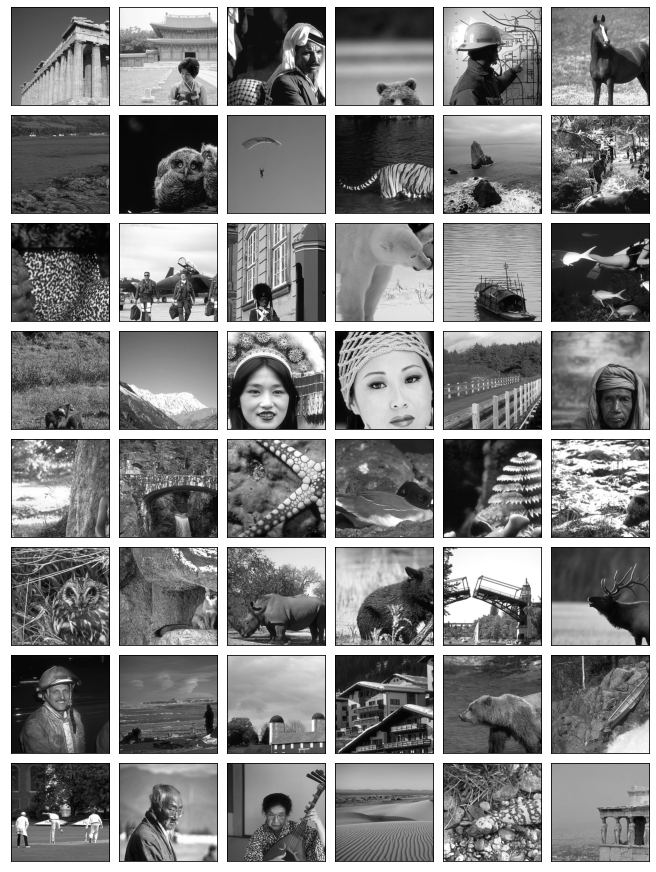


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the training blur images]



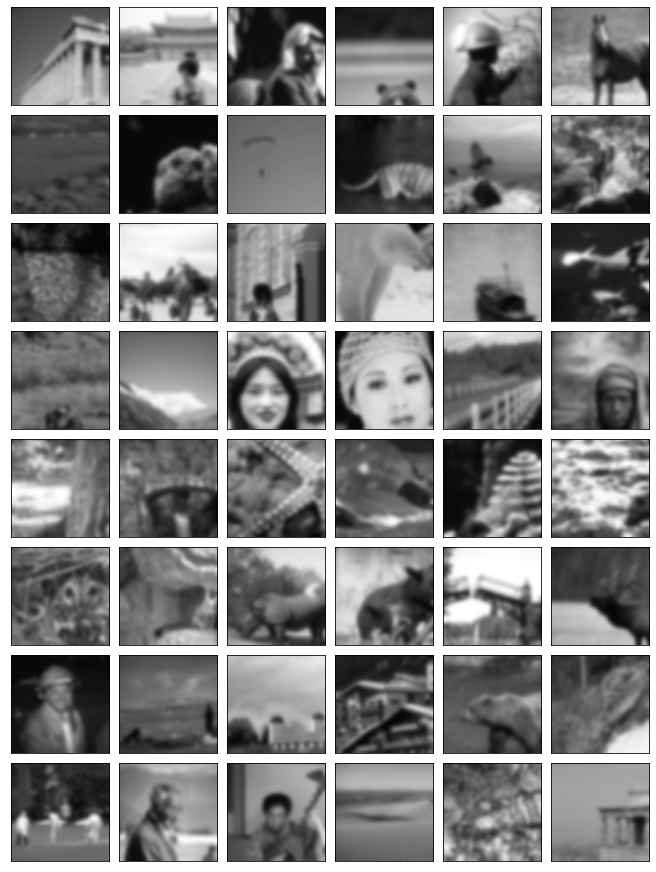


################################################################################
#
# RESULT # 03
#
################################################################################

[plot examples of the training de-blurring results]



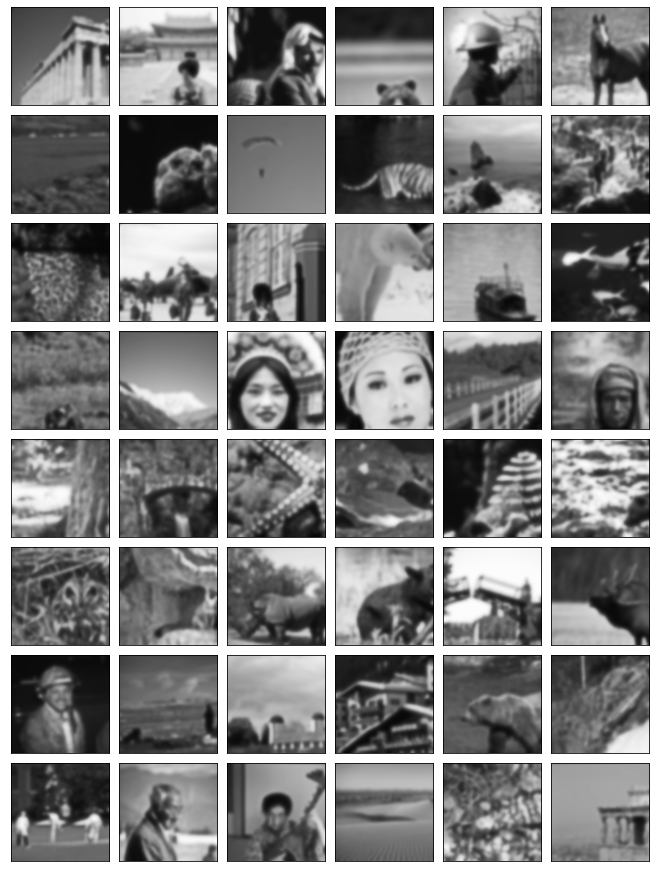


################################################################################
#
# RESULT # 04
#
################################################################################

[plot examples of the testing original images]



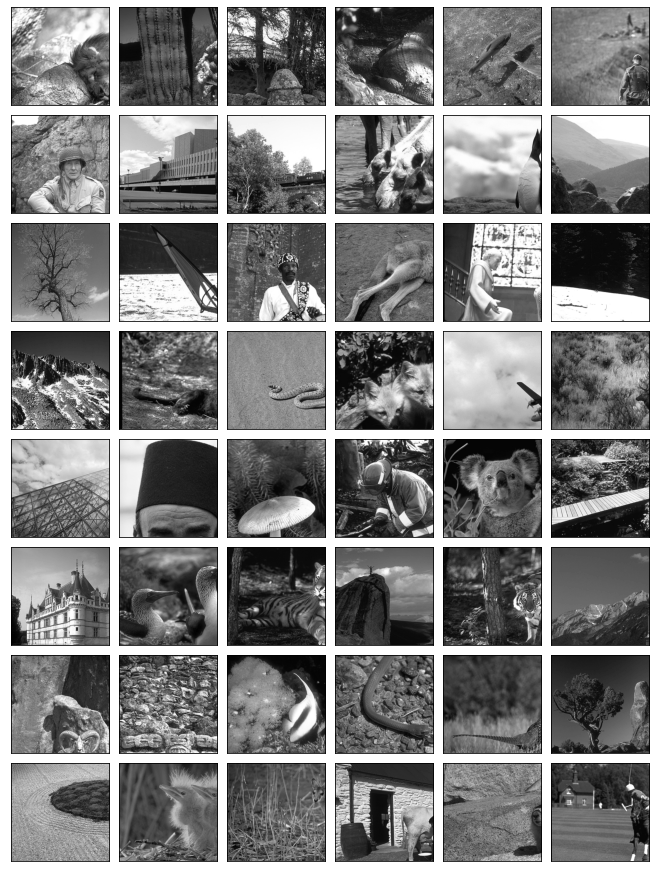


################################################################################
#
# RESULT # 05
#
################################################################################

[plot examples of the testing blur images]



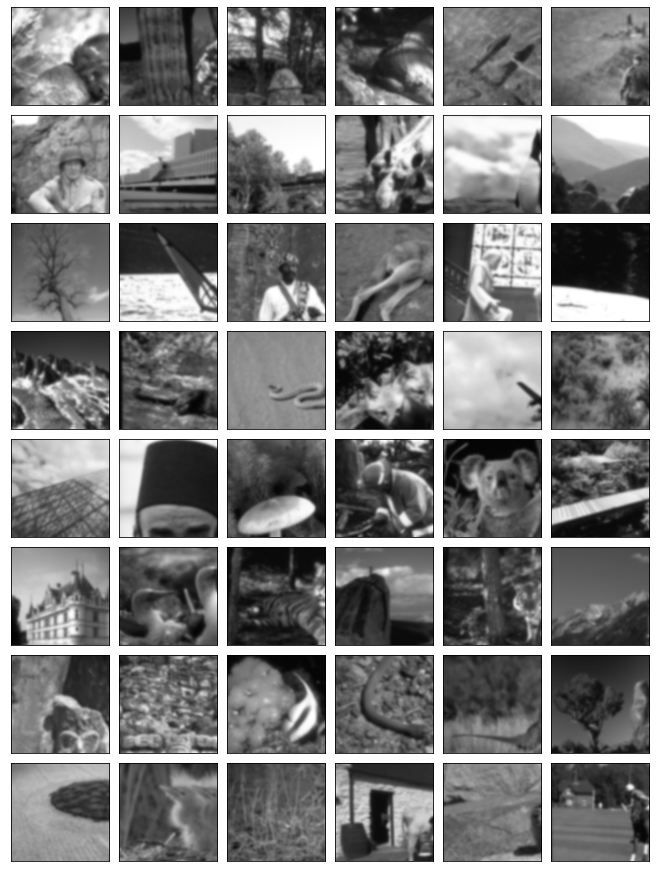


################################################################################
#
# RESULT # 06
#
################################################################################

[plot examples of the testing de-blurring results]



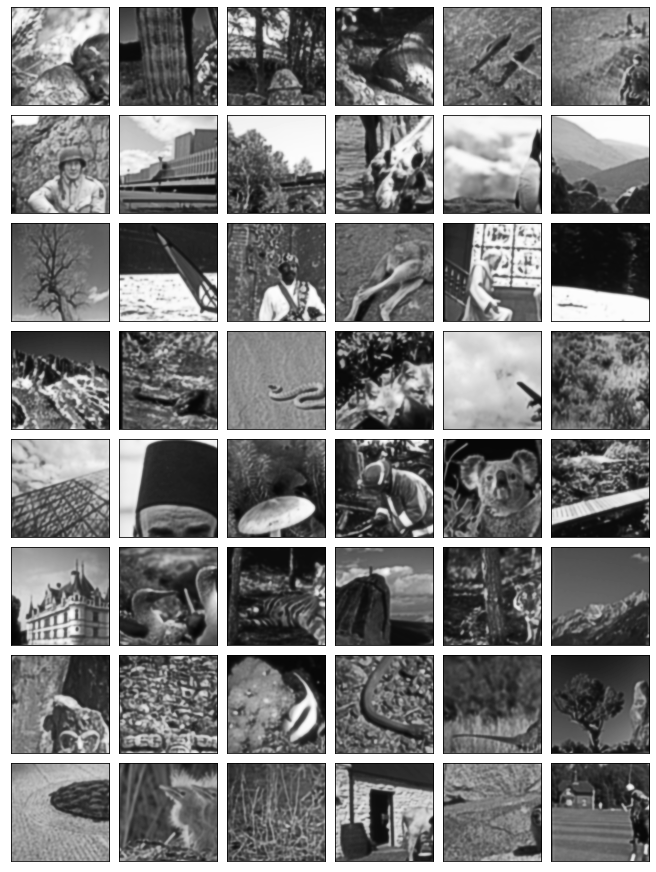


################################################################################
#
# RESULT # 07
#
################################################################################

[plot the training loss]



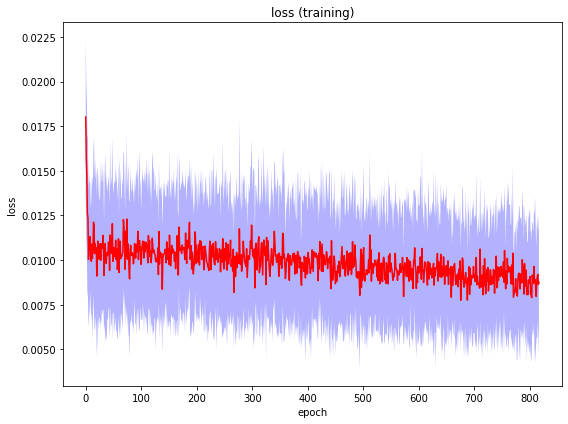


################################################################################
#
# RESULT # 08
#
################################################################################

[plot the training accuracy]



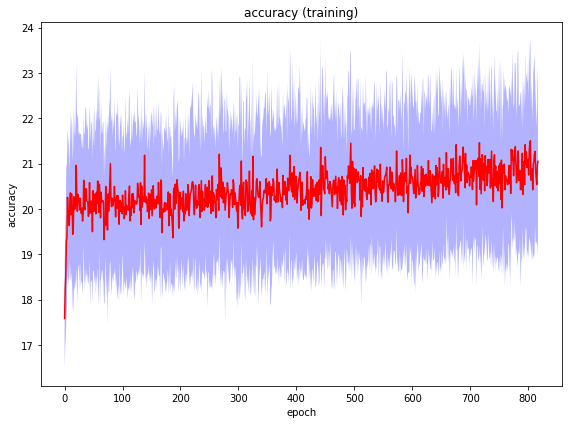


################################################################################
#
# RESULT # 09
#
################################################################################

[plot the testing loss]



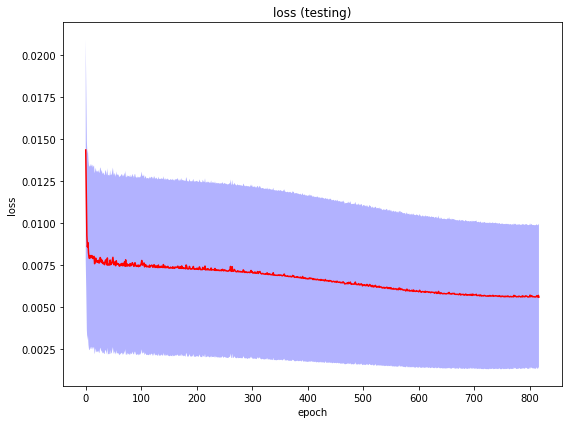


################################################################################
#
# RESULT # 10
#
################################################################################

[plot the testing accuracy]



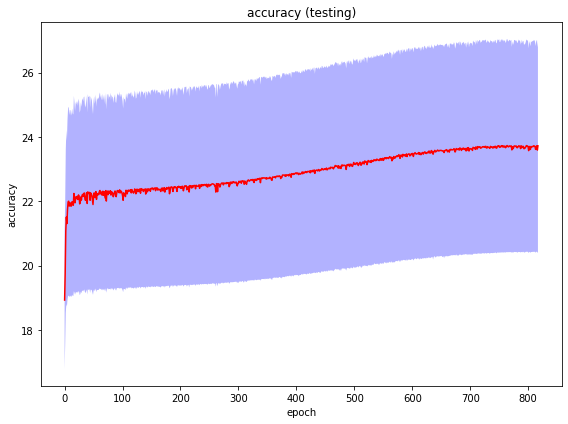


################################################################################
#
# RESULT # 11
#
################################################################################

[print the training loss at the last 10 epochs]

index =  0, value = 0.0096406395
index =  1, value = 0.0087786480
index =  2, value = 0.0089019956
index =  3, value = 0.0084804922
index =  4, value = 0.0079711954
index =  5, value = 0.0087385175
index =  6, value = 0.0090722853
index =  7, value = 0.0091933958
index =  8, value = 0.0086391130
index =  9, value = 0.0087598730

################################################################################
#
# RESULT # 12
#
################################################################################

[print the training accuracy at the last 10 epochs]

index =  0, value = 20.4215790558
index =  1, value = 20.9919764709
index =  2, value = 21.0419669342
index =  3, value = 21.2139512634
index =  4, value = 21.2694157410
index =  5, value = 20.8655571747


In [ ]:
number_result = 16

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)